In [1]:
import cv2
import numpy as np
import os
from random import shuffle
from tqdm import tqdm

In [2]:
pwd

'C:\\Users\\Usha\\Downloads'

In [3]:
cv2.__version__

'3.4.0'

In [4]:
TRAIN_DIR='C:\\Users\\Usha\\Desktop\\images\\train'
TEST_DIR='C:\\Users\\Usha\\Desktop\\images\\test'

In [5]:
IMG_SIZE=50
LR=1e-3

In [6]:
MODEL_NAME = 'peoplecount-{}-{}.model'.format(LR, '2conv-basic')

In [7]:
def label_img(img):
    word_label = img.split('.')[0]
  
    if word_label == 'no': 
        return [1,0,0,0]
    elif word_label == 'one':
        return [0,1,0,0]
    elif word_label == 'two':
        return [0,0,1,0]
    elif word_label == 'three':
        return [0,0,0,1]
      

In [8]:
def create_train_data():
    training_data = []
    for img in tqdm(os.listdir(TRAIN_DIR)):
        label = label_img(img)
        path = os.path.join(TRAIN_DIR,img)
        img = cv2.imread(path,cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
        training_data.append([np.array(img),np.array(label)])
    shuffle(training_data)
    np.save('train_data.npy', training_data)
    return training_data

In [9]:
def process_test_data():
    testing_data = []
   
    for img in tqdm(os.listdir(TEST_DIR)):
        label = label_img(img)
        path = os.path.join(TEST_DIR,img)
        img_num = img.split('.')[0]
        img = cv2.imread(path,cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
        testing_data.append([np.array(img),label])
        
    shuffle(testing_data)
    np.save('test_data.npy', testing_data)
    return testing_data

In [10]:
train_data= create_train_data()

100%|█████████████████████████████████████████| 93/93 [00:00<00:00, 104.42it/s]


In [11]:
import tensorflow as tf
import tflearn

C:\Users\Usha\Anaconda3\pyton\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [12]:
from tflearn.layers.conv import conv_2d, max_pool_2d
from tflearn.layers.core import input_data, dropout, fully_connected
from tflearn.layers.estimator import regression

convnet = input_data(shape=[None, IMG_SIZE, IMG_SIZE, 1], name='input')


convnet = conv_2d(convnet, 32, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 64, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 128, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 64, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 32, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = fully_connected(convnet, 1024, activation='relu')
convnet = dropout(convnet, 0.8)

convnet = fully_connected(convnet, 4, activation='softmax')
convnet = regression(convnet, optimizer='adam', learning_rate=LR, loss='categorical_crossentropy', name='targets')

model = tflearn.DNN(convnet, tensorboard_dir='log')

Instructions for updating:
Use tf.initializers.variance_scaling instead with distribution=uniform to get equivalent behavior.
Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [13]:
if os.path.exists('{}.meta'. format(MODEL_NAME)):
    model.load(MODEL_NAME)
    print('model loaded!')

In [14]:
train = train_data[:-5]
test = train_data[-5:]

In [15]:


X = np.array([i[0] for i in train]).reshape(-1,50,50,1)
Y = [i[1] for i in train]

test_x = np.array([i[0] for i in test]).reshape(-1,50,50,1)
test_y = [i[1] for i in test]



In [16]:
model.fit({'input': X}, {'targets': Y}, n_epoch=50, validation_set=({'input': test_x}, {'targets': test_y}), 
    snapshot_step=20, show_metric=True, run_id=MODEL_NAME)

Training Step: 99  | total loss: 0.85195 | time: 0.188s
| Adam | epoch: 050 | loss: 0.85195 - acc: 0.6728 -- iter: 64/88
Training Step: 100  | total loss: 0.83830 | time: 1.578s
| Adam | epoch: 050 | loss: 0.83830 - acc: 0.6639 | val_loss: 3.44333 - val_acc: 0.0000 -- iter: 88/88
--


In [17]:
import matplotlib.pyplot as plt

# if you need to create the data:
test_data = process_test_data()
# if you already have some saved:
#test_data = np.load('test_data.npy')



100%|█████████████████████████████████████████| 32/32 [00:00<00:00, 128.01it/s]


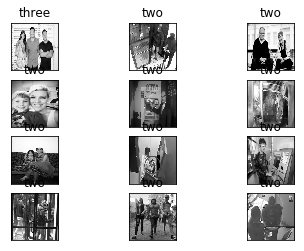

In [18]:
fig=plt.figure()

for num,data in enumerate(test_data[:12]):
  
    
    img_num = data[1]
    img_data = data[0]
    
    y = fig.add_subplot(4,3,num+1)
    orig = img_data
    data = img_data.reshape(IMG_SIZE,IMG_SIZE,1)
    #model_out = model.predict([data])[0]
    model_out = model.predict([data])[0]
    
    if np.argmax(model_out) == 3: str_label='three'
    elif np.argmax(model_out) == 2: str_label='two'
    elif np.argmax(model_out) == 1: str_label='one'
    else: str_label ='no'
        
    y.imshow(orig,cmap='gray')
    plt.title(str_label)
    y.axes.get_xaxis().set_visible(False)
    y.axes.get_yaxis().set_visible(False)
plt.show()